### Data downloaded from https://simplemaps.com/data/us-cities

In [54]:
import pandas as pd
import requests
import json 
import numpy as np
import matplotlib.pyplot as pl

In [55]:
import os
import pickle
import geopandas as gpd
from shapely.geometry import Polygon, Point

### Finding driving distance
We use Open Source Routing Machine (OSRM) api to calculate this. 

http://project-osrm.org/docs/v5.24.0/api/?language=Python#general-options

In [56]:
def distance_between(loc1,loc2):

    """
    input:
        loc1: source location (lat,long)
        loc2: destination location (lat,long)
    output:
        distance: road distance in Km
        duration: time in mins
    """

    r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{loc1[1]},{loc1[0]};{loc2[1]},{loc2[0]}?overview=false""")
    # print(r.content)
    try: 
        content = json.loads(r.content)['routes'][0]
    except: 
        print(r.content)
        return False
    distance,duration = content['distance'],content['duration']

    return distance/1000, duration/60


In [58]:
def get_city_data():
    final_file = '../data/cities_data/simplemaps_uscities_basicv1.76/uscitites_clean.csv'
    if os.path.isfile(final_file):
        with open(final_file,'rb') as f:
            data = pickle.load(f)
        return data
    
    file_name = 'cities_data/simplemaps_uscities_basicv1.76/uscities.csv'
    city_data = pd.read_csv(file_name)
    required_cols = ['city','state_id','state_name','county_name','lat','lng','population','density']
    city_data_filtered = city_data.filter(required_cols,axis=1)
    with open(final_file,'wb') as f:
        pickle.dump(city_data_filtered,f)
    return city_data_filtered

In [59]:
city_data = get_city_data()

In [61]:
city_data

,city,state_id,state_name,county_name,lat,lng,population,density
0,New York,NY,New York,Queens,40.6943,-73.9249,18972871,10768.2
1,Los Angeles,CA,California,Los Angeles,34.1141,-118.4068,12121244,3267.6
2,Chicago,IL,Illinois,Cook,41.8375,-87.6866,8595181,4576.6
3,Miami,FL,Florida,Miami-Dade,25.7840,-80.2101,5711945,4945.7
4,Dallas,TX,Texas,Dallas,32.7935,-96.7667,5668165,1522.2
...,...,...,...,...,...,...,...,...
30839,Ironville,PA,Pennsylvania,Blair,40.6586,-78.2155,0,59.2
30840,Newkirk,NM,New Mexico,Guadalupe,35.0635,-104.2715,0,0.0
30841,Falcon Village,TX,Texas,Starr,26.5652,-99.1341,0,38.9
30842,Hidden Lakes,OH,Ohio,Morrow,40.5479,-82.7632,0,18.6


In [62]:
loc1= (city_data.loc[city_data['city']=="Santa Barbara"][['lat','lng']]).values[0]
loc2 = (city_data.loc[city_data['city']=="Burbank"][['lat','lng']]).values[0]
print(loc1,loc2)
distance_between(loc1,loc2)

[  34.4285 -119.7202] [  34.1879 -118.3235]


(146.6678, 109.50333333333333)

### US state grid

In [63]:

def state_polygon(state_name):
    """Returns Polygon of a US state

    Args:
        state_name (str): US state name

    Returns:
        polygon: Polygon for the state boundary
    """
    boundaries = pd.read_csv('../data/cities_data/us-state-boundaries.csv',sep=';')
    assert state_name in boundaries['name'].values, "State not in the list"
    
    boundaries = boundaries.filter(['name','St Asgeojson'],axis=1)
    state = json.loads((boundaries.loc[boundaries['name']==state_name]).values[0][1])
    polygon = Polygon(state['coordinates'][0][0])
    return polygon

def state_grid(state_name,resolution):
    """creates grid of points inside the state

    Args:
        state_name (str): name of the US state
        resolution (float): distance resolution for the grid (units of miles)
    output:
        valid_points: list of (latitude,longitude) of points inside the state
    """

    polygon = state_polygon(state_name)
    

    ## Creating grid points inside the state
    x_min,y_min,x_max,y_max = polygon.bounds
    lat_dist_per_degree = 111/1.6 #in miles
    long_dist_per_degree = np.cos((y_min+y_max)*0.5)*111/1.6 #in miles
    resolution_lat = resolution/lat_dist_per_degree
    resolution_long = resolution/long_dist_per_degree
    gridx_points = np.arange(x_min,x_max,resolution_long)
    gridy_points = np.arange(y_min,y_max,resolution_lat)
    # print(grid_points[0].flatten(),grid_points[1].flatten())
    valid_points = []
    invalid_points = []
    for x in gridx_points:
        for y in gridy_points:
            # print(Point(x,y).within(polygon))
            if Point(x,y).within(polygon):
                valid_points.append((x,y))
            else:
                invalid_points.append((x,y))
    return valid_points, polygon

In [64]:
CA_grid, CA_polygon = state_grid('California',25)

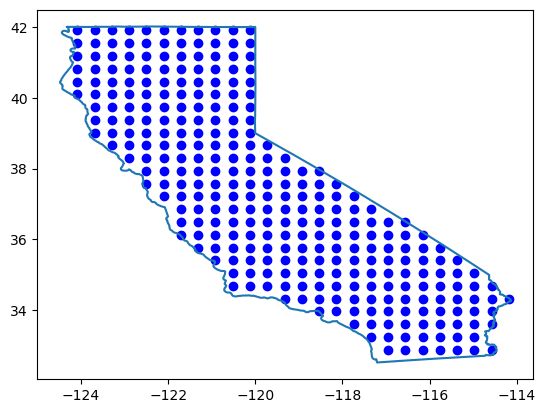

In [65]:
colors = ['blue','red']
pl.plot(*CA_polygon.exterior.xy)
[pl.scatter(p[0],p[1],color='blue') for p in CA_grid]
# [pl.scatter(*p,color='red') for p in invalid_points]



In [66]:
len(CA_grid) #total number of grid points

301

## Driving distance to cities

In [67]:
state_name = 'California'
cities = (city_data[city_data['state_name']==state_name].reset_index(drop=True)).copy(deep=True)
cities.sort_values(by='population',ascending=False,inplace=True)
population_threshold = 80000
cities = cities.loc[cities['population']>population_threshold]

In [68]:
cities

,city,state_id,state_name,county_name,lat,lng,population,density
0,Los Angeles,CA,California,Los Angeles,34.1141,-118.4068,12121244,3267.6
1,San Francisco,CA,California,San Francisco,37.7558,-122.4449,3290197,7199.4
2,San Diego,CA,California,San Diego,32.8313,-117.1222,3084174,1675.9
3,Riverside,CA,California,Riverside,33.9381,-117.3949,2022285,1557.0
4,Sacramento,CA,California,Sacramento,38.5677,-121.4685,1924167,1971.3
...,...,...,...,...,...,...,...,...
111,Redwood City,CA,California,San Mateo,37.5025,-122.2253,83905,1687.6
112,Alhambra,CA,California,Los Angeles,34.0840,-118.1355,83174,4275.8
113,Madera,CA,California,Madera,36.9630,-120.0778,82772,1536.8
114,Lakewood,CA,California,Los Angeles,33.8471,-118.1222,82419,3272.3


In [75]:
def distance_from_cities(lat,lng,radii=None):
    """Generate driving distance of a point from major cities in a state

    Args:
        lat (float): latitude of the location 
        lng (float): longitude of the location
        radii (float, optional): Threshold for the distance in miles. Defaults to None. This is obsolete in the current version

    Returns:
        distance_list: distance of to all cities within the radii
        population_list: population of cities within the radii
    """
    distance_list = []
    population_list = []
    city_name_list = []
    city_loc_list = []
    totol_pop = 0

    if radii is None:
        radii = 100000000 # some random value which is not possible in physical scenario
    lat_radii = radii/(111/1.6) # in miles
    lng_radii = abs(radii/(111*np.cos(lat)/1.6)) #in miles
    
    city_locs = cities[['lng','lat']].values
    city_names = cities['city'].values
    city_pop = cities['population'].values
    
    
    dist_in_degrees = np.abs(city_locs - np.array([lng,lat]).reshape((1,2)))
    dist_in_degrees = np.sum(np.abs(dist_in_degrees[:]),axis=-1)    
    sorted_indices = dist_in_degrees.argsort()

    # sorting cities according to the distance from the location
    city_locs = city_locs[sorted_indices]
    city_names = city_names[sorted_indices]
    city_pop = city_pop[sorted_indices]

    # for index,city in cities.iterrows():
    for i,city in enumerate(city_locs):

        city_lng,city_lat = city[0],city[1]
        result = distance_between((lat,lng),(city_lat,city_lng))
        if not result:
            return False
        else:
            dist,_ = result
        distance_list.append(dist)
        city_loc_list.append((city_lat,city_lng))
        city_name_list.append(city_names[i])
        population_list.append(city_pop[i])
        totol_pop += population_list[-1]
        if totol_pop > 100000:
            break
    
    index = list(range(len(distance_list)))
    index = sorted(index,key=lambda x:distance_list[x])
    distance_list = [distance_list[x] for x in index]
    population_list = [population_list[x] for x in index]
    city_loc_list = [city_loc_list[x] for x in index]
    city_name_list = [city_name_list[x] for x in index]

    return distance_list, population_list, city_name_list, city_loc_list

In [70]:
test = pd.read_csv('../data/ca_data_version_6.csv')
test

,lat,lon,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,...,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,demand_5km_MWh,demand_10km_MWh,demand_20km_MWh,demand_50km_MWh
0,41.121933,-124.083541,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,4.647099,"[74220.87028531785, 81853.14136114981, 113785....","[89.71184293662846, 99.27773039711408, 142.244...","[2.893930417310596, 3.54563322846836, 4.588518...","[78072.6330660135, 86028.3788149819, 119490.90...",1.351093e+06,0.0,0.0,0.0,0.0
1,34.571305,-120.610359,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,5.449958,"[126910.2673240865, 120953.4951399055, 141626....","[157.4086237937431, 149.0061670892798, 176.243...","[5.07769754173365, 5.321648824617137, 5.685276...","[132842.0433185665, 126964.0270624705, 148524....",1.584719e+06,0.0,0.0,0.0,0.0
2,37.426206,-121.839995,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,5.776466,"[93296.39819471513, 94001.73832147277, 148309....","[115.084787852927, 118.3805626840665, 188.1425...","[3.712412511384743, 4.227877238716659, 6.06911...","[97913.03195989196, 98663.10917491073, 155325....",1.631746e+06,0.0,0.0,4414158.0,5241628.0
3,33.750032,-117.072459,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,6.246080,"[135309.814274307, 123283.186730356, 151155.07...","[170.4540593143596, 156.1909634208012, 197.380...","[5.498518042398696, 5.578248693600041, 6.36712...","[141635.9382116481, 129010.6773886973, 158297....",1.729305e+06,0.0,0.0,0.0,2857331.0
4,35.705444,-121.063383,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,6.172914,"[118738.5864463819, 113457.5578228151, 148653....","[145.3158467865841, 140.9581036133796, 186.941...","[4.687607960857552, 5.034217986192131, 6.03037...","[124417.4689334649, 118908.0059730483, 155818....",1.773539e+06,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,39.635821,-123.695234,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,5.284656,"[82206.5215781221, 79078.58223682463, 119457.0...","[101.4403464882599, 97.9490161792885, 151.1051...","[3.272269241556772, 3.498179149260304, 4.87436...","[86334.0767633393, 83172.89206218862, 125334.8...",1.497264e+06,0.0,0.0,0.0,0.0
996,41.063271,-121.192818,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,5.759330,"[99114.67518039557, 102305.487932296, 138174.3...","[118.7602691333396, 124.2157409854216, 172.137...","[3.830976423656115, 4.436276463765057, 5.55283...","[103913.1240378555, 107965.9059896455, 145940....",1.632927e+06,0.0,0.0,0.0,0.0
997,38.579898,-120.545641,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,5.939311,"[110443.9698609668, 99928.59308818416, 133367....","[136.2651011977622, 125.3747863465937, 169.904...","[4.395648425734264, 4.477670940949776, 5.48078...","[115801.7524074974, 104800.1668133905, 139813....",1.655084e+06,0.0,0.0,0.0,0.0
998,40.183336,-121.257536,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,5.875154,"[99694.60795598329, 102037.4288268836, 150853....","[124.0439463477292, 129.623619731286, 198.3924...","[4.001417624120297, 4.629414990403072, 6.39975...","[104512.3474230356, 106988.9897269136, 157887....",1.582795e+06,0.0,0.0,0.0,0.0


In [154]:
# generating locations list
loc_data = pd.read_csv('../data/ca_data_version_12.csv')
locations  = loc_data.loc[loc_data['State']=='CA'][['Latitude','Longitude']].values

# state_name = 'California' # state to focus on
# locations,state_polygon = state_grid(state_name,resolution=25) # change this to change the dataset



In [155]:
len(locations)

5000

In [156]:
dist_list_100, pop_list_100,name_list_100,loc_list_100 = distance_from_cities(locations[0][0],locations[0][1],radii=100)
locations[0],loc_list_100,distance_between(locations[0],(37.4001, -122.0796))

(array([  34.08245206, -117.39604782]),
 [(34.1175, -117.3892)],
 (644.4552, 455.995))

In [157]:
df_copy = None

In [168]:
# Generate a dataframe for a list of locations

radii = 50 #in mile

if df_copy is None:  
    df = pd.DataFrame({'lng':[],'lat':[],'number of cities':[],'total population':[],'min distance':[],'max distance':[],'name of the nearest city':[],'coordinates of the nearest city (lat,lng)':[],'distance list':[],'population list':[],'cities name':[],'cities locations':[]})
else:
    df = df_copy.copy(deep=True)
nearest_dist = 0
nearest_city = ''
for i,loc in enumerate(locations[len(df):]):
    #loc[0] is lat and lat[1] is lng
    print(loc)
    # df['drivin radii'].append(radii)
    result = distance_from_cities(loc[0],loc[1],radii=radii)
    if not result:
        df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
            'name of the nearest city':None,
            'coordinates of the nearest city (lat,lng)':None,
            'distance list':[],'population list':[],'cities name':[],'cities locations':[]},ignore_index=True)
    else:
        dist_list, pop_list, name_list, loc_list = result
        city_count = len(dist_list)
        population = np.sum(pop_list)

        if city_count== 0:
            min_distance = None
            max_distance = None
            name_of_the_nearest_city = None
            coordinates = None
        else:
            min_distance = dist_list[0]
            max_distance = dist_list[-1]
            name_of_the_nearest_city = name_list[0]
            coordinates = loc_list[0]

        # print([loc[0],loc[1],radii,city_count,population])

        df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,
        'name of the nearest city':name_of_the_nearest_city,
         'coordinates of the nearest city (lat,lng)':coordinates,
        'distance list':dist_list,'population list':pop_list,'cities name':name_list,'cities locations':loc_list},ignore_index=True)
    
    if (i+1)%100 == 0:
        df_copy = df.copy(deep=True)

[  33.24162514 -115.73496093]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.65226154 -117.35290271]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.660855   -122.24987316]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.53219669 -120.58878626]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.3198416  -115.71338838]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.97372083 -122.42245361]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.75040508 -124.25612096]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.24747843 -123.06963032]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.75314524 -123.22063822]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.82002808 -121.81842202]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.04919712 -123.71680703]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.25569893 -120.95551973]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.69174273 -124.27769352]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.98468149 -120.35148814]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.9346126 -122.8323322]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.67181566 -118.04322454]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.33391538 -120.91237462]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.30340061 -123.7815247 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.82862153 -122.27144571]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.76995919 -122.3793085 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.6272271  -121.30068065]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.30340061 -121.90471224]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.53530982 -124.42870142]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.92601915 -120.00632722]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.01830939 -121.60269644]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.95964704 -121.49483366]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.96550034 -123.99725027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.4207253  -122.09886526]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.60219266 -120.26519791]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.18881609 -122.35773594]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.02652988 -118.64725613]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  39.89002404 -123.9325326 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.35894983 -115.97225906]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.02652988 -114.63476053]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.24162514 -115.60552559]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.02104955 -120.67507649]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.2502186  -120.89080206]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.13563407 -121.71055923]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.82862153 -124.16983073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.13015374 -122.44402617]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.02378972 -119.98475467]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.92875931 -118.60411102]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  37.83684203 -121.58112389]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.63308039 -122.57346151]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.1829628 -115.7996786]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.11059963 -121.40854343]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.32569489 -123.04805777]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.95416672 -122.85390475]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.24747843 -120.97709229]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.50442208 -122.0772927 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.7641059  -121.38697087]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.9346126  -122.48717128]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.83098874 -118.47467568]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  39.44027941 -121.12810019]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.13563407 -121.66741412]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.21385053 -121.79684946]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.86461664 -120.63193138]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.10474634 -115.73496093]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.27525304 -120.93394718]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.52671636 -121.51640622]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.88965108 -118.38838545]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  39.45983353 -123.84624238]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15244802 -120.93394718]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.39805806 -115.99383162]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.92327898 -120.71822161]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.89276421 -123.75995215]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.84780269 -120.09261745]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.82862153 -124.25612096]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.94557326 -119.96318211]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.77817969 -122.12043781]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.50168192 -122.16358293]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.97372083 -123.00491265]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.04371679 -124.21297584]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.25881205 -124.12668562]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.19155625 -120.84765695]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.06563811 -118.60411102]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  37.46531385 -121.96942991]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.97646099 -120.71822161]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.52123603 -122.48717128]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.87595026 -122.3793085 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.47353435 -120.48092348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.77543952 -123.60894425]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.29792028 -124.14825817]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.82276824 -121.43011599]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.66633533 -118.32366778]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.78091985 -120.80451183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.91779865 -121.90471224]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.92875931 -117.24503993]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.82002808 -121.83999457]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.66359516 -121.88313969]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.16378164 -124.32083863]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.1829628  -115.73496093]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.50442208 -122.57346151]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.0042356  -120.48092348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.02416268 -121.66741412]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.2502186  -120.95551973]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46805402 -116.92145157]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.98505445 -124.16983073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.63270743 -117.95693431]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.02690284 -124.10511306]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.90646503 -117.6117734 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.47627451 -118.64725613]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  40.94594622 -124.19140329]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.96512737 -120.37306069]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.79499363 -123.63051681]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.74766491 -124.19140329]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.20251691 -115.7996786 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.5157557  -122.35773594]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.01282906 -122.89704987]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.31436127 -120.89080206]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.86772976 -124.16983073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.73907146 -122.20672804]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.83684203 -122.63817918]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.55212377 -124.12668562]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.49582863 -115.9506865 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.97372083 -121.4732611 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.10785947 -121.90471224]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.13015374 -122.3793085 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.40665151 -120.93394718]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.13289391 -120.91237462]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.20288987 -124.36398374]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.23340465 -121.88313969]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.86187647 -121.51640622]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.13015374 -122.27144571]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.60219266 -122.18515548]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.53767702 -117.1587497 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.56308443 -122.55188895]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.00734873 -124.04039539]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.18333576 -124.27769352]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.77817969 -122.35773594]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.73907146 -122.27144571]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.88691092 -118.45310312]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.97098066 -122.72446941]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.97098066 -123.41479123]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.24747843 -122.98334009]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.59397216 -122.42245361]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.67455582 -115.36822746]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.0042356  -118.77669147]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.66633533 -118.43153056]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.04334383 -120.20048024]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.75003212 -114.50532518]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.06601107 -124.0835405 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.96512737 -120.28677047]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.66633533 -118.45310312]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.9092052 -117.3097576]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.92601915 -117.59020084]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.37850394 -115.92911395]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.67218862 -124.29926607]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.36480312 -123.13434799]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.16652181 -123.82466982]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.7281108  -124.27769352]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.45983353 -121.66741412]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.39805806 -115.90754139]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.71403701 -123.88938749]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.23066448 -120.84765695]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.02104955 -117.3097576 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.59397216 -124.3855563 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.62996726 -120.69664905]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.3198416  -115.75653349]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.30614077 -121.66741412]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.80321413 -121.36539832]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.24747843 -120.50249604]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.40665151 -122.44402617]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.0714914  -122.72446941]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.53256965 -124.10511306]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.24473827 -121.94785736]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.59397216 -124.34241119]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.3198416 -115.7996786]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.82588137 -124.29926607]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.12741358 -122.03414759]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.1829628  -115.71338838]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.01282906 -122.94019498]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95690688 -121.7752769 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.1747423  -121.71055923]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.54353031 -122.20672804]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.91779865 -122.09886526]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.30614077 -121.1712453 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.01282906 -123.02648521]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.4543532  -124.10511306]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.06289795 -120.09261745]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30028748 -115.90754139]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.7281108  -124.19140329]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.28073337 -115.69181582]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.730478   -118.15108732]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.85054285 -117.1587497 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.53256965 -122.87547731]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.1829628  -115.82125116]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.26117926 -117.4607655 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.33939571 -117.6117734 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.26117926 -118.28052266]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  33.00697577 -117.28818504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.19429642 -121.81842202]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.63308039 -124.27769352]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.84506252 -120.67507649]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.43442612 -120.13576257]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.88965108 -115.51923536]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.67492878 -121.94785736]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.59945249 -123.43636379]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.99327494 -121.624269  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.4567204  -117.33133015]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.98742165 -118.53939335]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  39.32295472 -121.83999457]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.6272271  -121.19281786]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.16340868 -117.41762038]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.24747843 -121.71055923]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.77232639 -118.34524033]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  38.71677718 -123.50108146]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.6944829  -123.84624238]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.18881609 -122.98334009]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.83684203 -122.59503407]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.52123603 -121.36539832]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.79188051 -118.409958  ]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  41.76721903 -124.32083863]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.94557326 -120.24362535]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.06289795 -119.920037  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.51538274 -117.76278129]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.61078611 -124.19140329]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.97372083 -122.81075964]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.0714914  -121.99100247]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.85091581 -123.88938749]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.50442208 -122.5303164 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.97372083 -122.8323322 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.99327494 -122.40088105]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.06289795 -119.94160955]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.15792835 -120.69664905]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.43753925 -121.88313969]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.70818372 -120.67507649]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.1133398  -122.35773594]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.87009697 -117.28818504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.46531385 -122.55188895]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.85054285 -117.28818504]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.046084   -117.33133015]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.2083702  -122.42245361]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.62174677 -122.50874384]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.33702851 -124.19140329]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.9092052  -118.43153056]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  37.46531385 -122.12043781]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.61900661 -123.39321868]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.11607996 -121.71055923]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.24162514 -115.77810605]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.51849587 -123.80309726]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.89824454 -120.41620581]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.59397216 -123.58737169]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.57167788 -124.10511306]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.83098874 -118.34524033]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  40.33976867 -123.91096005]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.20014971 -124.14825817]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.18059559 -122.14201037]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.45398023 -120.39463325]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.73907146 -120.37306069]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.04371679 -124.16983073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.19429642 -121.79684946]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.32021456 -124.3855563 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.88143059 -121.4732611 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.4567204  -118.38838545]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  38.63856072 -123.45793635]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.48486797 -122.48717128]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.4543532  -122.85390475]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.26117926 -114.6994782 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.02378972 -120.09261745]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.54353031 -122.18515548]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.25843909 -114.13859171]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.92365194 -124.27769352]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.65500171 -117.1587497 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.50442208 -122.18515548]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.41487201 -120.43777837]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.75040508 -122.20672804]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.22244399 -122.5303164 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.90646503 -120.00632722]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.90683799 -122.70289685]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.34250884 -121.81842202]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.24162514 -117.43919294]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.85054285 -118.32366778]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  34.68862961 -120.65350394]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.44575974 -121.94785736]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.8673568  -120.11419001]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.71129685 -124.27769352]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.1133398  -119.87689188]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.60767299 -121.25753553]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.77232639 -118.409958  ]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  37.75862557 -123.13434799]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.90646503 -118.47467568]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.12156029 -120.43777837]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.5157557  -124.45027397]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.22792432 -121.73213179]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.77817969 -123.11277544]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.67181566 -118.06479709]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.87595026 -122.33616338]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.62448693 -121.94785736]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.49582863 -116.94302413]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.04371679 -124.0835405 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.89002404 -123.99725027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.41487201 -119.83374677]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.24747843 -122.29301827]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.13289391 -122.3793085 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.68588944 -118.28052266]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.92601915 -120.24362535]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47079418 -121.02023741]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.05193729 -122.12043781]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.84780269 -117.43919294]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.78677314 -124.25612096]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95690688 -120.71822161]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.7977338  -122.57346151]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.34250884 -123.86781493]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.76136574 -122.01257503]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.49582863 -116.01540418]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.57441805 -124.16983073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.86187647 -121.45168855]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.90683799 -124.21297584]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.660855   -120.67507649]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.71092389 -118.34524033]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.79188051 -118.34524033]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  33.98468149 -119.87689188]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.31747439 -124.2345484 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.67218862 -124.36398374]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.54353031 -122.57346151]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.70818372 -120.63193138]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.09104552 -122.01257503]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.87009697 -117.3097576 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.65226154 -118.06479709]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.77269936 -123.84624238]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.98468149 -118.53939335]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.26117926 -114.67790564]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.16340868 -115.64867071]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.90646503 -120.20048024]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.51538274 -116.01540418]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.40939168 -121.96942991]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.38435723 -121.624269  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.49894175 -123.80309726]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.00697577 -118.51782079]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  36.50716225 -121.94785736]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.43716628 -116.03697673]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.05193729 -122.42245361]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.90372487 -116.72729856]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.42620563 -119.94160955]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.89550437 -122.33616338]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.2419981  -124.40712886]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.5239762  -122.57346151]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.8649896  -124.25612096]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.15244802 -122.2283006 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.82824857 -117.87064408]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.77817969 -122.55188895]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.2083702  -121.34382576]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.86772976 -124.19140329]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.56856476 -121.12810019]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.8649896  -124.40712886]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.87595026 -122.72446941]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.19429642 -121.83999457]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.30614077 -123.11277544]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.43716628 -115.9506865 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.82588137 -122.96176754]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.76721903 -124.14825817]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.72225751 -121.99100247]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.7977338  -123.06963032]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.83958219 -121.90471224]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.69174273 -122.46559873]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.07423157 -122.33616338]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.63308039 -124.29926607]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.0378635  -121.64584156]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.09378568 -120.80451183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.64404105 -121.83999457]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.69136977 -118.21580499]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.11059963 -122.85390475]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.53804998 -123.82466982]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30028748 -115.84282372]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.51849587 -121.624269  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.40665151 -120.99866485]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.68040911 -122.3793085 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.4821278  -123.26378334]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.01556922 -120.71822161]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.94868639 -124.04039539]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.43716628 -118.58253846]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  40.12467342 -124.2345484 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.2083702  -122.57346151]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.88454371 -124.2345484 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.49582863 -118.5609659 ]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  36.33117522 -121.90471224]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.61078611 -124.12668562]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.94320606 -124.25612096]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.15792835 -120.71822161]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.44301958 -122.78918708]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.0042356  -119.89846444]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.660855   -122.14201037]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.96550034 -124.16983073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.37576378 -119.920037  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.40391135 -123.13434799]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.94283309 -116.59786321]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.56856476 -121.14967275]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.5239762  -121.08495508]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.82862153 -122.40088105]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.74729195 -120.69664905]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.50442208 -122.2283006 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.69722306 -121.12810019]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30028748 -115.73496093]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.18059559 -124.12668562]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.70855668 -124.25612096]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.10200618 -120.43777837]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.71951734 -123.09120288]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.84817565 -124.10511306]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30028748 -118.45310312]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  33.90646503 -119.96318211]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.84817565 -124.2345484 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.30028748 -118.47467568]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  39.77269936 -123.86781493]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.14970786 -121.94785736]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.46257369 -123.19906566]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.08245206 -120.39463325]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.81728791 -122.48717128]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.74181162 -121.83999457]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.98468149 -120.48092348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.18881609 -122.29301827]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.24162514 -115.67024326]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.99327494 -122.3793085 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.14970786 -122.3793085 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.2083702  -121.36539832]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.66359516 -121.83999457]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.59671233 -123.84624238]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.74455179 -121.36539832]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.45709336 -124.40712886]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.04919712 -123.75995215]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.00734873 -124.0835405 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.5239762  -122.14201037]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.56034426 -123.32850101]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.660855   -122.35773594]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.97372083 -121.51640622]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.11059963 -122.31459083]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.22792432 -121.60269644]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.04334383 -120.24362535]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.50716225 -121.99100247]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.51301554 -124.14825817]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.46805402 -121.96942991]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.14970786 -122.35773594]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.69996323 -122.55188895]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.84780269 -118.409958  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.18881609 -122.55188895]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.79225347 -123.84624238]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.48486797 -122.09886526]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.09104552 -121.96942991]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.06289795 -120.13576257]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.13015374 -122.94019498]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.7977338  -122.33616338]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.90646503 -117.63334595]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.78677314 -124.21297584]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.19155625 -120.95551973]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.56582459 -121.99100247]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.26117926 -115.73496093]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.04334383 -120.09261745]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.73633129 -123.58737169]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.71951734 -122.3793085 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.50990241 -121.08495508]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.60767299 -121.1712453 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.42346546 -121.66741412]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.52671636 -122.01257503]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.98468149 -120.26519791]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.67181566 -117.05088691]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.01008889 -123.71680703]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.04334383 -120.04947234]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.43716628 -115.90754139]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.59397216 -124.36398374]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.5576041 -121.4732611]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.49346142 -124.12668562]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.12430045 -117.39604782]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.20288987 -124.34241119]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.80906742 -124.14825817]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.41761217 -115.90754139]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.61900661 -122.24987316]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.99327494 -122.70289685]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.09652585 -116.83516134]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.49582863 -115.82125116]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.80869446 -118.47467568]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.78091985 -122.01257503]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.68040911 -122.24987316]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.01282906 -122.91862242]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.80632726 -124.19140329]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.08519223 -118.62568358]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  32.98742165 -118.49624823]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,


b'{"message":"Impossible route between points","code":"NoRoute"}'
[  39.04919712 -123.69523448]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.43442612 -118.60411102]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.9346126  -122.24987316]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.07423157 -121.06338252]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.83098874 -117.3097576 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.26117926 -115.71338838]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.30340061 -122.0772927 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.73359113 -123.84624238]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.9346126  -122.46559873]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.83410186 -120.73979416]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.23066448 -120.80451183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.08245206 -119.89846444]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81143462 -118.43153056]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  33.4567204  -117.71963618]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.13015374 -122.33616338]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.40391135 -123.15592055]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.0042356  -118.79826403]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.046084   -117.35290271]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.45398023 -120.52406859]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.64678121 -121.3222532 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.47079418 -115.34665491]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.45983353 -123.86781493]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.2083702  -120.56721371]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.01282906 -122.46559873]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.99327494 -122.94019498]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.91505849 -122.46559873]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.47627451 -115.9506865 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.78091985 -121.88313969]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.0042356  -120.50249604]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.8673568  -117.09403203]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.11059963 -122.0772927 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.88454371 -124.3855563 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.09104552 -121.88313969]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.44575974 -122.46559873]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.32295472 -122.09886526]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.1411144  -120.52406859]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.58263854 -122.29301827]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.33702851 -124.16983073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.53493686 -117.84907152]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.32295472 -121.90471224]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.33939571 -115.71338838]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.91779865 -121.99100247]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.60219266 -120.54564115]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.30614077 -121.38697087]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.28073337 -115.82125116]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.7641059 -121.3222532]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.99327494 -122.8323322 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.33976867 -122.20672804]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.16340868 -117.39604782]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.70270339 -121.86156713]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.06875124 -123.71680703]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.61315331 -117.91378919]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.83098874 -117.33133015]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.10785947 -121.34382576]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.6526345  -122.94019498]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.47664747 -124.42870142]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.72499767 -121.3222532 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.30614077 -122.44402617]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.38161707 -123.7815247 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.00460856 -124.14825817]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.51264258 -117.26661248]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.11607996 -121.66741412]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.12156029 -119.87689188]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.01556922 -122.24987316]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.24747843 -122.31459083]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.09104552 -121.71055923]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.63582055 -123.82466982]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.67455582 -117.26661248]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.9682405  -124.06196795]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.41761217 -118.51782079]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  33.06563811 -117.11560458]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.84780269 -120.11419001]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.50990241 -121.12810019]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.44575974 -122.0772927 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.43716628 -118.45310312]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  34.59085904 -120.67507649]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.11059963 -121.58112389]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.90957816 -123.99725027]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.06601107 -124.12668562]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.81728791 -122.44402617]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.5576041  -121.96942991]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.46531385 -122.50874384]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.28073337 -115.73496093]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.53530982 -122.35773594]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.98468149 -120.45935092]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.60219266 -121.34382576]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.71951734 -122.27144571]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.72225751 -121.90471224]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.53804998 -121.36539832]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.02964301 -122.89704987]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.23066448 -122.46559873]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.74455179 -120.95551973]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.63034023 -124.12668562]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.11059963 -122.48717128]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95690688 -121.96942991]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.26977271 -122.46559873]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.4207253  -123.75995215]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.69996323 -122.24987316]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.19429642 -121.75370434]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.1133398 -122.3793085]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.49308846 -118.75511892]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.61900661 -123.41479123]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.26977271 -120.86922951]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.6272271  -121.27910809]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.02964301 -122.87547731]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.28073337 -117.52548317]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.73633129 -121.10652763]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.32295472 -122.0772927 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.53219669 -120.61035882]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.44027941 -122.18515548]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.02378972 -120.2220528 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.75003212 -118.17265988]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.29792028 -124.16983073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.65500171 -117.18032225]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.69136977 -115.62709815]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.62174677 -120.56721371]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.21111037 -120.65350394]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.71951734 -123.06963032]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.05193729 -121.60269644]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.730478   -118.43153056]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.49582863 -118.45310312]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  38.79499363 -123.67366192]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.48760813 -121.96942991]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.77232639 -118.38838545]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  40.41798513 -124.40712886]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.02690284 -122.01257503]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.60219266 -122.33616338]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.05193729 -121.9262848 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.14970786 -120.80451183]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.26429238 -123.75995215]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.91231832 -123.75995215]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.33939571 -117.33133015]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.02378972 -119.920037  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.32295472 -121.7752769 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.12430045 -115.75653349]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.05193729 -122.0772927 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.14422753 -124.21297584]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.65811483 -123.43636379]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.55175081 -120.58878626]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.04371679 -124.12668562]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.12467342 -124.25612096]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.4903483  -121.10652763]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.32569489 -123.09120288]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.08245206 -120.50249604]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.01282906 -122.01257503]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.43442612 -120.52406859]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.046084   -118.51782079]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  33.06563811 -118.62568358]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,


b'{"message":"Impossible route between points","code":"NoRoute"}'
[  37.60219266 -122.29301827]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.52123603 -122.16358293]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.04919712 -122.87547731]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.03238317 -122.05572014]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.08830535 -122.89704987]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.42346546 -120.99866485]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.85365598 -123.65208936]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.82588137 -124.40712886]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.04334383 -119.96318211]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.3534695  -120.86922951]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.33939571 -118.28052266]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  38.09104552 -122.8323322 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.71677718 -123.54422658]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.33939571 -115.92911395]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.23614481 -120.89080206]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.660855   -122.33616338]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.70855668 -124.21297584]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.51538274 -118.60411102]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  38.05193729 -122.31459083]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.61589348 -117.18032225]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.26977271 -120.93394718]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.44301958 -123.19906566]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.67181566 -118.34524033]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.5935992  -117.93536175]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.18059559 -124.16983073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.43442612 -120.24362535]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.17200214 -120.89080206]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.28658666 -121.25753553]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.05193729 -121.64584156]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.660855   -120.65350394]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.13015374 -122.0772927 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.51849587 -123.82466982]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.65500171 -117.26661248]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.74455179 -121.38697087]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.28073337 -118.47467568]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  38.05193729 -121.79684946]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.21111037 -122.42245361]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.78091985 -121.90471224]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.345249   -123.06963032]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.6526345  -124.34241119]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.76136574 -120.35148814]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.89550437 -122.78918708]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.37850394 -115.97225906]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.38983756 -121.96942991]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.03238317 -122.14201037]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.08519223 -114.6994782 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.97098066 -123.7815247 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.9682405  -124.04039539]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.68040911 -123.00491265]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.52123603 -123.35007356]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.87595026 -122.6813243 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.03512334 -122.27144571]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.28073337 -115.75653349]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.94868639 -124.01882283]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.34798917 -122.42245361]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.26977271 -120.82608439]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.02378972 -118.75511892]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.02378972 -120.02789978]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.22518415 -123.82466982]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.44027941 -122.96176754]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.10785947 -123.73837959]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.53219669 -120.65350394]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.4567204  -117.67649107]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.81143462 -117.07245947]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.26117926 -115.64867071]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.64130088 -122.24987316]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.84506252 -120.2220528 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.73085096 -124.25612096]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.92875931 -118.43153056]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  41.82588137 -124.2345484 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.3198416  -117.50391061]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.18881609 -122.12043781]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.10785947 -122.87547731]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.3116211 -121.9262848]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.75314524 -123.86781493]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.94557326 -118.51782079]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.18881609 -122.01257503]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.07423157 -122.35773594]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.59945249 -123.39321868]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.8313617  -123.26378334]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.77817969 -122.33616338]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.1411144  -120.50249604]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.68588944 -121.34382576]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.28658666 -122.98334009]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.71951734 -122.29301827]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.86187647 -121.43011599]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.47938764 -123.82466982]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.30340061 -123.84624238]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.05193729 -122.48717128]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.65537467 -123.80309726]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.66633533 -118.409958  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.78951331 -124.27769352]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.35894983 -115.9506865 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.85913631 -121.94785736]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.6272271  -121.21439042]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.11607996 -116.83516134]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.35894983 -115.90754139]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.66944845 -124.19140329]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.2419981  -124.34241119]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.7977338  -122.50874384]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.06327091 -124.21297584]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.95690688 -122.01257503]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.09378568 -121.14967275]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.12156029 -120.54564115]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.68588944 -121.36539832]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.54079015 -123.35007356]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.02964301 -122.76761452]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.76136574 -121.99100247]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.13015374 -122.09886526]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.76136574 -121.86156713]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.2083702 -121.9262848]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.74766491 -124.10511306]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.43716628 -115.86439628]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.591232   -122.96176754]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.08245206 -120.02789978]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.96512737 -120.26519791]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.62174677 -122.5303164 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.35932279 -124.40712886]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.09378568 -121.12810019]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.44575974 -122.03414759]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.58263854 -122.24987316]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.8673568  -120.13576257]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.78951331 -124.25612096]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.56034426 -121.55955133]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.38161707 -122.01257503]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.09104552 -122.29301827]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.10474634 -115.71338838]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.43442612 -120.2220528 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.92601915 -120.02789978]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.07423157 -121.02023741]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.10200618 -118.00007942]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.26155222 -124.36398374]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.92639211 -124.10511306]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.23066448 -122.42245361]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.08245206 -119.920037  ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.91779865 -122.01257503]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.33939571 -117.59020084]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.3788769  -124.40712886]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.07423157 -122.27144571]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.83958219 -121.83999457]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.10200618 -120.48092348]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.33976867 -124.3855563 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.84817565 -124.12668562]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.96786754 -118.49624823]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  39.98779461 -124.10511306]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.04334383 -119.89846444]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.22518415 -121.9262848 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.88691092 -120.00632722]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.6944829  -123.86781493]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  32.59633936 -117.09403203]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.67181566 -118.08636965]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.03238317 -121.90471224]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  40.30066045 -124.40712886]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.81454775 -121.10652763]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.01282906 -122.33616338]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.70855668 -124.2345484 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.31747439 -124.10511306]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.99327494 -121.51640622]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.81728791 -123.11277544]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  34.68862961 -120.61035882]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.56308443 -122.29301827]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.39805806 -118.5609659 ]
b'{"message":"Impossible route between points","code":"NoRoute"}'
[  38.18881609 -122.33616338]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':0,'total   population':0,'min distance':None,'max distance':None,
/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  35.43168596 -121.04180996]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.13015374 -121.68898667]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.10237914 -124.16983073]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.57989838 -123.37164612]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.56034426 -123.39321868]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  38.93187244 -123.7815247 ]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.1829628  -115.67024326]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  37.97372083 -120.54564115]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.90646503 -120.02789978]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  33.41761217 -115.99383162]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  41.68900257 -122.46559873]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  36.68314928 -120.32991558]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


[  39.8313617 -123.9325326]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_66414/1125395041.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[1],'lat':loc[0],'number of cities':int(city_count),'total population':int(population),'min distance':min_distance,'max distance':max_distance,


In [169]:
print(len(locations),len(df_copy))

5000 5000


In [172]:
df.head()

,Longitude,Latitude,number of cities,total population,min distance,max distance,name of the nearest city,"coordinates of the nearest city (lat,lng)",distance list,population list,cities name,cities locations,total population
0,-117.396048,34.082452,1.0,103799.0,4.9767,4.9767,Rialto,"(34.1175, -117.3892)",[4.9767],[103799],[Rialto],"[(34.1175, -117.3892)]",NaN
1,-117.137177,33.710924,1.0,101089.0,8.2905,8.2905,Menifee,"(33.6909, -117.1849)",[8.2905],[101089],[Menifee],"[(33.6909, -117.1849)]",NaN
2,-122.357736,39.948686,1.0,121498.0,83.4367,83.4367,Redding,"(40.5698, -122.365)",[83.4367],[121498],[Redding],"[(40.5698, -122.365)]",NaN
3,-121.645842,37.934613,1.0,322796.0,17.8811,17.8811,Antioch,"(37.9787, -121.796)",[17.8811],[322796],[Antioch],"[(37.9787, -121.796)]",NaN
4,-121.991002,37.973721,1.0,640270.0,1.1831,1.1831,Concord,"(37.9722, -122.0016)",[1.1830999999999998],[640270],[Concord],"[(37.9722, -122.0016)]",NaN


In [171]:
df.rename(columns={'lat':'Latitude','lng':'Longitude'},inplace=True)

In [173]:
# with open('../data/cities_data_resolution_2_km.pd','wb') as f:
#     pickle.dump(df,f)

In [174]:
# df.to_csv('../data/cities_data_resolution_2_km.csv')

### Merging cities data with the final database

In [175]:
final_data = pd.read_csv('../data/ca_data_version_12.csv')

In [176]:
final_data

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,...,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,Unnamed: 21,0.0
0,34.082452,-117.396048,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,354.0,ac_annual,6.137753,"[126643.6284333316, 123642.4656084192, 146079....","[160.3371500625433, 157.9419747969732, 190.017...","[5.172166131049785, 5.640784814177614, 6.12959...","[132621.8932622115, 129576.8218587892, 153178....",1.696741e+06,0,0
1,33.710924,-117.137177,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,446.0,ac_annual,6.204925,"[126868.3514493219, 123183.8261829259, 150337....","[163.6214888471466, 159.1281172506521, 198.769...","[5.278112543456341, 5.683147044666148, 6.41193...","[132793.0245010775, 128887.8434912795, 157389....",1.690435e+06,0,0
2,39.948686,-122.357736,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,139.0,ac_annual,5.701319,"[81871.68545656932, 90825.3059124629, 139086.2...","[100.9587614211884, 113.1211746079644, 177.813...","[3.256734239393176, 4.040041950284444, 5.73593...","[86019.00030301968, 95337.82386751169, 145682....",1.566192e+06,0,0
3,37.934613,-121.645842,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,ac_annual,5.892671,"[93225.92555313384, 117872.5185756382, 133564....","[113.2858897184085, 147.74228808641, 170.25043...","[3.654383539303501, 5.276510288800359, 5.49194...","[97835.782674236, 123415.2943375236, 139980.07...",1.657431e+06,0,0
4,37.973721,-121.991002,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,54.0,ac_annual,5.897817,"[96173.72130512354, 120312.542412835, 141419.0...","[116.6067532589445, 150.3203686240996, 179.493...","[3.761508169643369, 5.368584593717842, 5.79011...","[100873.0371669258, 125951.7057612103, 148151....",1.666310e+06,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,33.906465,-120.027900,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,ac_annual,5.657576,"[124430.625264793, 128050.6419688767, 145367.7...","[153.6989610932505, 160.3153573714344, 182.836...","[4.958031003008081, 5.725548477551228, 5.89796...","[130265.685683405, 134053.1184491426, 152307.0...",1.630118e+06,0,0
4996,33.417612,-115.993832,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,-70.0,ac_annual,6.323911,"[134881.0702731289, 134061.3259228609, 160552....","[171.7044746679793, 171.4122722654111, 210.579...","[5.538854021547718, 6.121866866621824, 6.79290...","[141101.3654307219, 140161.8184159705, 167980....",1.721495e+06,0,0
4997,41.689003,-122.465599,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,798.0,ac_annual,5.611707,"[93573.38738081408, 97924.47093016192, 131421....","[114.6791140404956, 121.3874734554713, 166.397...","[3.699326259370827, 4.335266909123976, 5.36766...","[98146.2203916726, 102768.3713357534, 137701.7...",1.557846e+06,0,0
4998,36.683149,-120.329916,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,49.0,ac_annual,5.919039,"[87091.30519709826, 105473.3029344761, 150766....","[107.8239676379539, 132.2051590546551, 193.002...","[3.478192504450126, 4.72161282338054, 6.225877...","[91538.11642345533, 110607.0393392461, 158047....",1.633566e+06,0,0


In [177]:
df = pd.read_csv('../data/cities_data_resolution_2_km.csv',index_col=0)

In [178]:
df = df[['Longitude','Latitude','min distance']]
df

,Longitude,Latitude,min distance
0,-117.396048,34.082452,4.9767
1,-117.137177,33.710924,8.2905
2,-122.357736,39.948686,83.4367
3,-121.645842,37.934613,17.8811
4,-121.991002,37.973721,1.1831
...,...,...,...
4995,-120.027900,33.906465,18.4074
4996,-115.993832,33.417612,46.7102
4997,-122.465599,41.689003,152.5223
4998,-120.329916,36.683149,61.3323


In [179]:
final_data_city = final_data.join(df.set_index(['Latitude','Longitude']),on=['Latitude','Longitude'])

In [181]:
final_data_city.loc[(final_data_city['Latitude']<38.089889).values * (final_data_city['Latitude']>38.089887).values]

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,...,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,Unnamed: 21,0.0,min distance


In [182]:
final_data_city.rename(columns={'min distance':'min_distance'},inplace=True)

In [184]:
# filename = 'ca_data_version_13.csv'
# final_data_city.to_csv('../data/'+ filename,index=False)

In [185]:
test = pd.read_csv('../data/ca_data_version_13.csv')

In [186]:

test.loc[test['State']=='CA']

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,...,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,Unnamed: 21,0.0,min_distance
0,34.082452,-117.396048,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,ac_annual,6.137753,"[126643.6284333316, 123642.4656084192, 146079....","[160.3371500625433, 157.9419747969732, 190.017...","[5.172166131049785, 5.640784814177614, 6.12959...","[132621.8932622115, 129576.8218587892, 153178....",1.696741e+06,0,0,4.9767
1,33.710924,-117.137177,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,ac_annual,6.204925,"[126868.3514493219, 123183.8261829259, 150337....","[163.6214888471466, 159.1281172506521, 198.769...","[5.278112543456341, 5.683147044666148, 6.41193...","[132793.0245010775, 128887.8434912795, 157389....",1.690435e+06,0,0,8.2905
2,39.948686,-122.357736,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,ac_annual,5.701319,"[81871.68545656932, 90825.3059124629, 139086.2...","[100.9587614211884, 113.1211746079644, 177.813...","[3.256734239393176, 4.040041950284444, 5.73593...","[86019.00030301968, 95337.82386751169, 145682....",1.566192e+06,0,0,83.4367
3,37.934613,-121.645842,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,ac_annual,5.892671,"[93225.92555313384, 117872.5185756382, 133564....","[113.2858897184085, 147.74228808641, 170.25043...","[3.654383539303501, 5.276510288800359, 5.49194...","[97835.782674236, 123415.2943375236, 139980.07...",1.657431e+06,0,0,17.8811
4,37.973721,-121.991002,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,ac_annual,5.897817,"[96173.72130512354, 120312.542412835, 141419.0...","[116.6067532589445, 150.3203686240996, 179.493...","[3.761508169643369, 5.368584593717842, 5.79011...","[100873.0371669258, 125951.7057612103, 148151....",1.666310e+06,0,0,1.1831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,33.906465,-120.027900,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,ac_annual,5.657576,"[124430.625264793, 128050.6419688767, 145367.7...","[153.6989610932505, 160.3153573714344, 182.836...","[4.958031003008081, 5.725548477551228, 5.89796...","[130265.685683405, 134053.1184491426, 152307.0...",1.630118e+06,0,0,18.4074
4996,33.417612,-115.993832,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,ac_annual,6.323911,"[134881.0702731289, 134061.3259228609, 160552....","[171.7044746679793, 171.4122722654111, 210.579...","[5.538854021547718, 6.121866866621824, 6.79290...","[141101.3654307219, 140161.8184159705, 167980....",1.721495e+06,0,0,46.7102
4997,41.689003,-122.465599,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,ac_annual,5.611707,"[93573.38738081408, 97924.47093016192, 131421....","[114.6791140404956, 121.3874734554713, 166.397...","[3.699326259370827, 4.335266909123976, 5.36766...","[98146.2203916726, 102768.3713357534, 137701.7...",1.557846e+06,0,0,152.5223
4998,36.683149,-120.329916,0.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,ac_annual,5.919039,"[87091.30519709826, 105473.3029344761, 150766....","[107.8239676379539, 132.2051590546551, 193.002...","[3.478192504450126, 4.72161282338054, 6.225877...","[91538.11642345533, 110607.0393392461, 158047....",1.633566e+06,0,0,61.3323


### Analyzing dataset

In [187]:
CA_data = test.loc[test['State']=='CA']

In [188]:
CA_data['elevation']

0       354.0
1       446.0
2       139.0
3        10.0
4        54.0
        ...  
4995      0.0
4996    -70.0
4997    798.0
4998     49.0
4999      0.0
Name: elevation, Length: 5000, dtype: float64

In [190]:
lats = CA_data['Latitude'].values.copy()
lngs = CA_data['Longitude'].values.copy()
lats_solar_farm = CA_data.loc[CA_data['power']>0.01]['Latitude'].values.copy()
lngs_solar_farm = CA_data.loc[CA_data['power']>0.01]['Longitude'].values.copy()
lats_grid = CA_data.loc[np.isnan(CA_data['panel.area'])]['Latitude'].values.copy()
lngs_grid = CA_data.loc[np.isnan(CA_data['panel.area'])]['Longitude'].values.copy()

In [191]:
len(lats_solar_farm)

154

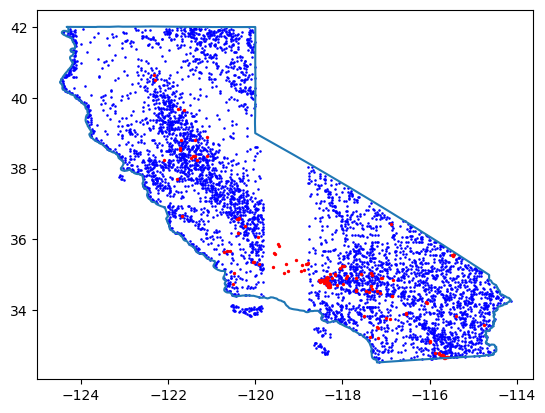

In [192]:
pl.plot(*CA_polygon.exterior.xy)
pl.scatter(lngs_grid,lats_grid,color='blue',s=0.7)
pl.scatter(lngs_solar_farm,lats_solar_farm,color='red',s=2)

In [194]:
cities_distance = CA_data['min_distance'].values.copy()
cities_distance_solar_farms = CA_data.loc[CA_data['power']>0.5]['min_distance'].values.copy()
cities_distance_grid = CA_data.loc[np.isnan(CA_data['panel.area'])]['min_distance'].values.copy()

In [195]:
np.any(np.isnan(cities_distance))

True

In [209]:
temp = CA_data.loc[(CA_data['elevation']<1500) * (CA_data['slope']<20) * (CA_data['land_cover']!=0)  * (CA_data['solrad_annual']>3.0)]
cities_distance_2 = temp['min_distance'].values.copy()
# len(cities_distance_2)
np.sum((cities_distance_2>100))

1442

In [131]:
# threshold for cities distance = 100

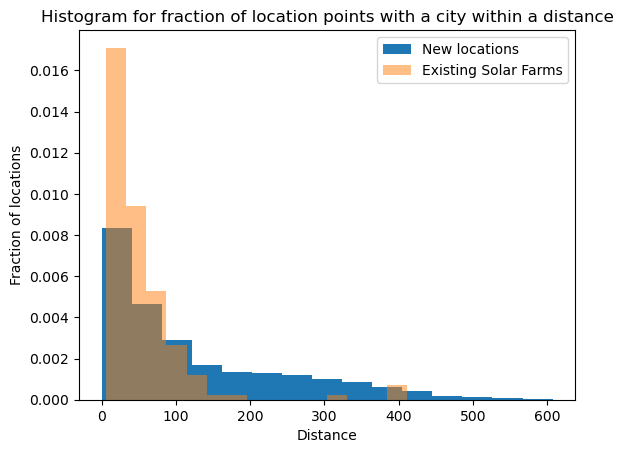

In [210]:
pl.hist(cities_distance,bins=15,density=True,label='New locations')
pl.hist(cities_distance_solar_farms,bins=15,density=True,alpha=0.5,label='Existing Solar Farms')
pl.title('Histogram for fraction of location points with a city within a distance')
pl.xlabel('Distance')
pl.ylabel('Fraction of locations')
pl.legend()

In [211]:
cities_lat = cities['Latitude'].values.copy()
cities_lng = cities['Longitude'].values.copy()

KeyError: 'Latitude'

Text(0.5, 1.0, 'Cities with min. population 88000 in CA')

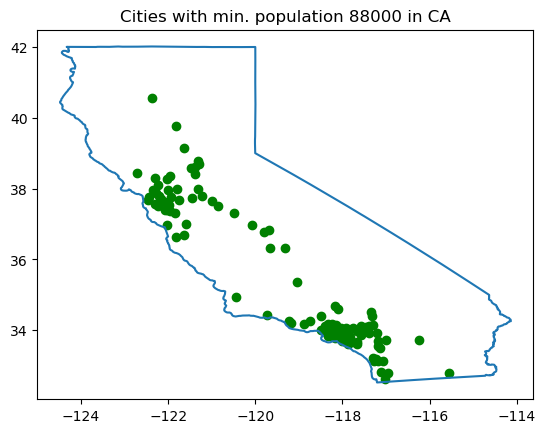

In [212]:
pl.plot(*CA_polygon.exterior.xy)
pl.scatter(cities_lng,cities_lat,color='green')
pl.title('Cities with min. population 88000 in CA')

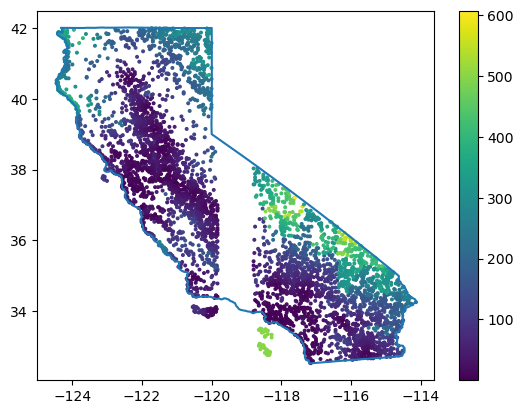

In [213]:
pl.plot(*CA_polygon.exterior.xy) 
max_dist = np.max(cities_distance)
cities_distance_grid[np.isnan(cities_distance_grid)]=500
# pl.tricontour(lngs[:],lats[:],cities_distance[:])
sc = pl.scatter(lngs_grid,lats_grid,c=cities_distance_grid,s= 3.5)
pl.colorbar(sc)
